Wahlpflichtfach Künstliche Intelligenz II: Testat 

---

# 01 - Testat zu Tensorflow (Regression)
__Gruppennummer:__ 1

__Mitglieder:__
- Lena Awe
- Leni Lakebrink
- Jannes Teupen
- Lucas Weihermann
- Jakob Zoll

In [1]:
%matplotlib inline

## Data Understanding
Laden Sie die Daten und machen Sie sich mit ihnen vertraut. Den Datensatz finden Sie unter folgendem [Link](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset).

In [2]:
import pandas as pd

from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)
df = pd.DataFrame(data=data.data, columns=data.feature_names)
df["target"] = data.target
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [3]:
# import seaborn as sns

# sns.set_theme(style="whitegrid")
# sns.pairplot(df, hue="target")

## Data Preperation (2 Punkte)
Die erste Aufgabe ist es den Datensatz fürs maschinelle Lernen vorzubereiten. Dazu sind die folgenden Schritte nötig:
* a) Auswahl der Strategie(n) zum Ersetzen der fehlenden Werte und anschließenden skalieren dieser
* b) Erstellen der Preparation-Pipeline

_Hinweise/Tipps:_
* Sie müssen die unterschiedlichen Algorithmen nicht (bis zum Maximum) optimieren, hier geht es gerade eher darum zu überprüfen, ob Sie die Algorithmen generell verstanden haben und Sie richtig einsetzen/kombinieren können.
* Gucken Sie sich nochmal die besprochenen Algorithmen aus dem Praktikum 1 an und überlegen wo die Stärken und Schwächen liegen.
* Sie können selbstverständlich auch unterschiedliche Methoden für die einzelnen Merkmale wählen.

### a) Auswahl der Strategie(n)
_Punkte: 1_

Als erstes müssen Sie sich eine Strategie zum Ersetzen der fehlenden Werte überlegen. Beschreiben Sie diese in der nachfolgenden Markdown-Zeile und begründen Sie, warum Sie diese Strategie gewählt haben. Außerdem sollten die Daten skaliert/normalisiert werden. Beschreiben Sie Ihre Strategie und begründen Sie, warum Sie diese Strategie bzw. Methoden gewählt haben. Erstellen sie zusätzlich einen Test und Trainingsdatensatz

**Ihre Antwort:**

Da es keine fehlenden Werte gibt, müssen keine Werte ersetzt werden. Wenn es fehlende Werte gegeben hätte, hätten wir diese mit dem IterativeImputer ersetzt, da sowohl auf Zeilen- wie auch auf Spalten-Ebene ein Zusammenhang zwischen den Daten besteht.

Für die Skalierung der Werte nutzen wir einen RobustScaler, damit Ausreißer die Ergebnisse nicht zu stark beeinflussen. Damit skalieren wir alle Werte bis auf Ausreißer auf einen Wertebreich von -1 bis 1. Alle Spalten bis auf die Zielvariable werden skaliert, da nur metrische Variablen vorliegen. 

Da wir nur die Skalierung verwenden, wird keine Pipeline benötigt. 

### b) Erstellen der Preparation-Pipeline
_Punkte: 1_

In [4]:
from sklearn.preprocessing import RobustScaler
import torch

# RobustScaler fuer Skalierung der Daten, um Ausreißer zu reduzieren
data_scaled = RobustScaler().fit_transform(df.drop(columns=['target']))
target = df['target']

n = len(data_scaled)
input_dim = data_scaled.shape[1]
x = torch.tensor(data_scaled, dtype=torch.float32)
y = torch.tensor(target, dtype=torch.float32).view(-1, 1)

## Modeling (3 Punkte)
Ihre nächste Aufgabe ist es das Training vorzubereiten und den richtigen ML-Algorithmus auszuwählen. Dafür müssen Sie die folgenden Teilaufgaben erledigen:
* a) Erstellen sie ein Multilayer Perceptron
* b) Entscheiden sie sich für eine Loss-Funktion, Optimierer und geeignete Metriken. Zusätzlich erstellen sie ein Tensorboard.
* c) Trainieren sie das neuronale Netz

### a) Erstellen sie ein Multilayer Perceptron
_Punkte: 1,5_

Denken sie an die Initialisierung der Gewichte im Layer sowie die Wahl der Aktivierungsfunktion


In [5]:
from datetime import datetime

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir=f'./data/01_testat_nn/runs/run_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

# Train/Val/Test Split: 60% Train, 20% Val, 20% Test
ids = torch.randperm(len(x))
train_ids = ids[:int(n * .6)]
val_ids = ids[int(n * .6):int(n * .8)]
test_ids = ids[int(n * .8):]

train_dataset = TensorDataset(x[train_ids], y[train_ids])
val_dataset = TensorDataset(x[val_ids], y[val_ids])
test_dataset = TensorDataset(x[test_ids], y[test_ids])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Training Daten werden geshuffelt
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # Validation Daten werden nicht geshuffelt
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Test Daten werden nicht geshuffelt

print(f"Training batches per epoch: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches per epoch: 387
Validation batches: 129
Test batches: 129


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class RegressionMLP(nn.Module):
    # Einfache MLP-Architektur (Funnel) mit 2 versteckten Schichten
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

model = RegressionMLP(input_dim=input_dim)

# Log the model architecture to TensorBoard
writer.add_graph(model, x[train_ids][:batch_size])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Model Architecture:
RegressionMLP(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

Total parameters: 2,689
Trainable parameters: 2,689


### b) Loss-Funktion, Optimierer und Metriken
_Punkte: 1_

In [7]:
import numpy as np

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # sollen wir standardmäßig als Optimizer verwenden
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=10,
)

def train_epoch(model, train_loader, criterion, optimizer):
    """Training fuer eine Epoche"""
    model.train()
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_X.size(0)
    
    return train_loss / len(train_loader.dataset)

def validate(model, val_loader, criterion):
    """Modell validieren und Validierungsverlust berechnen"""
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            val_loss += loss.item() * batch_X.size(0)
    
    return val_loss / len(val_loader.dataset)

def compute_metrics(model, data_loader):
    """Detailierte Metriken für Regression berechnen: MSE, RMSE, MAE"""
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            predictions = model(batch_X)
            all_predictions.append(predictions)
            all_targets.append(batch_y)
    
    predictions = torch.cat(all_predictions, dim=0)
    targets = torch.cat(all_targets, dim=0)
    
    mse = F.mse_loss(predictions, targets).item()        
    return {
        'mse': mse,                           
        'rmse': np.sqrt(mse),
        'mae': F.l1_loss(predictions, targets).item(),
    }

#### c) Trainieren des neuronale Netz
_Punkte: 0,5_

In [8]:
# Training loop
num_epochs = 100
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
early_stopping_patience = 20

for epoch in range(num_epochs):
    # Trainieren
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)

    # Validieren
    val_loss = validate(model, val_loader, criterion)
    val_losses.append(val_loss)

    # Losses in TensorBoard loggen
    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalars('Loss/Train_vs_Val', {'Train': train_loss, 'Validation': val_loss}, epoch)

    # Learning Rate anpassen basierend auf Validierungsverlust
    scheduler.step(val_loss)

    # Early Stopping und bestes Modell speichern
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        torch.save(model.state_dict(), './data/01_testat_nn/model.pth')
    else:
        patience_counter += 1

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Train Loss: {train_loss:7.4f} | "
              f"Val Loss: {val_loss:7.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

writer.close()

Epoch   1/100 | Train Loss:  4.4208 | Val Loss:  1.5817 | LR: 0.001000
Epoch  10/100 | Train Loss:  0.4051 | Val Loss:  0.4808 | LR: 0.001000
Epoch  20/100 | Train Loss:  0.3193 | Val Loss:  0.3519 | LR: 0.001000
Epoch  30/100 | Train Loss:  0.3047 | Val Loss:  0.3282 | LR: 0.001000
Epoch  40/100 | Train Loss:  0.2874 | Val Loss:  0.3220 | LR: 0.001000
Epoch  50/100 | Train Loss:  0.2755 | Val Loss:  0.3132 | LR: 0.001000
Epoch  60/100 | Train Loss:  0.2684 | Val Loss:  0.3051 | LR: 0.001000
Epoch  70/100 | Train Loss:  0.2585 | Val Loss:  0.3054 | LR: 0.001000
Epoch  80/100 | Train Loss:  0.2451 | Val Loss:  0.3096 | LR: 0.000500
Epoch  90/100 | Train Loss:  0.2509 | Val Loss:  0.3016 | LR: 0.000250

Early stopping triggered after 99 epochs


## Evaluation (2 Punkte)
Verwenden sie die Metriken sowie für das Problem geeignete Visualisierungen und erläutern sie ihre Ergebnisse.

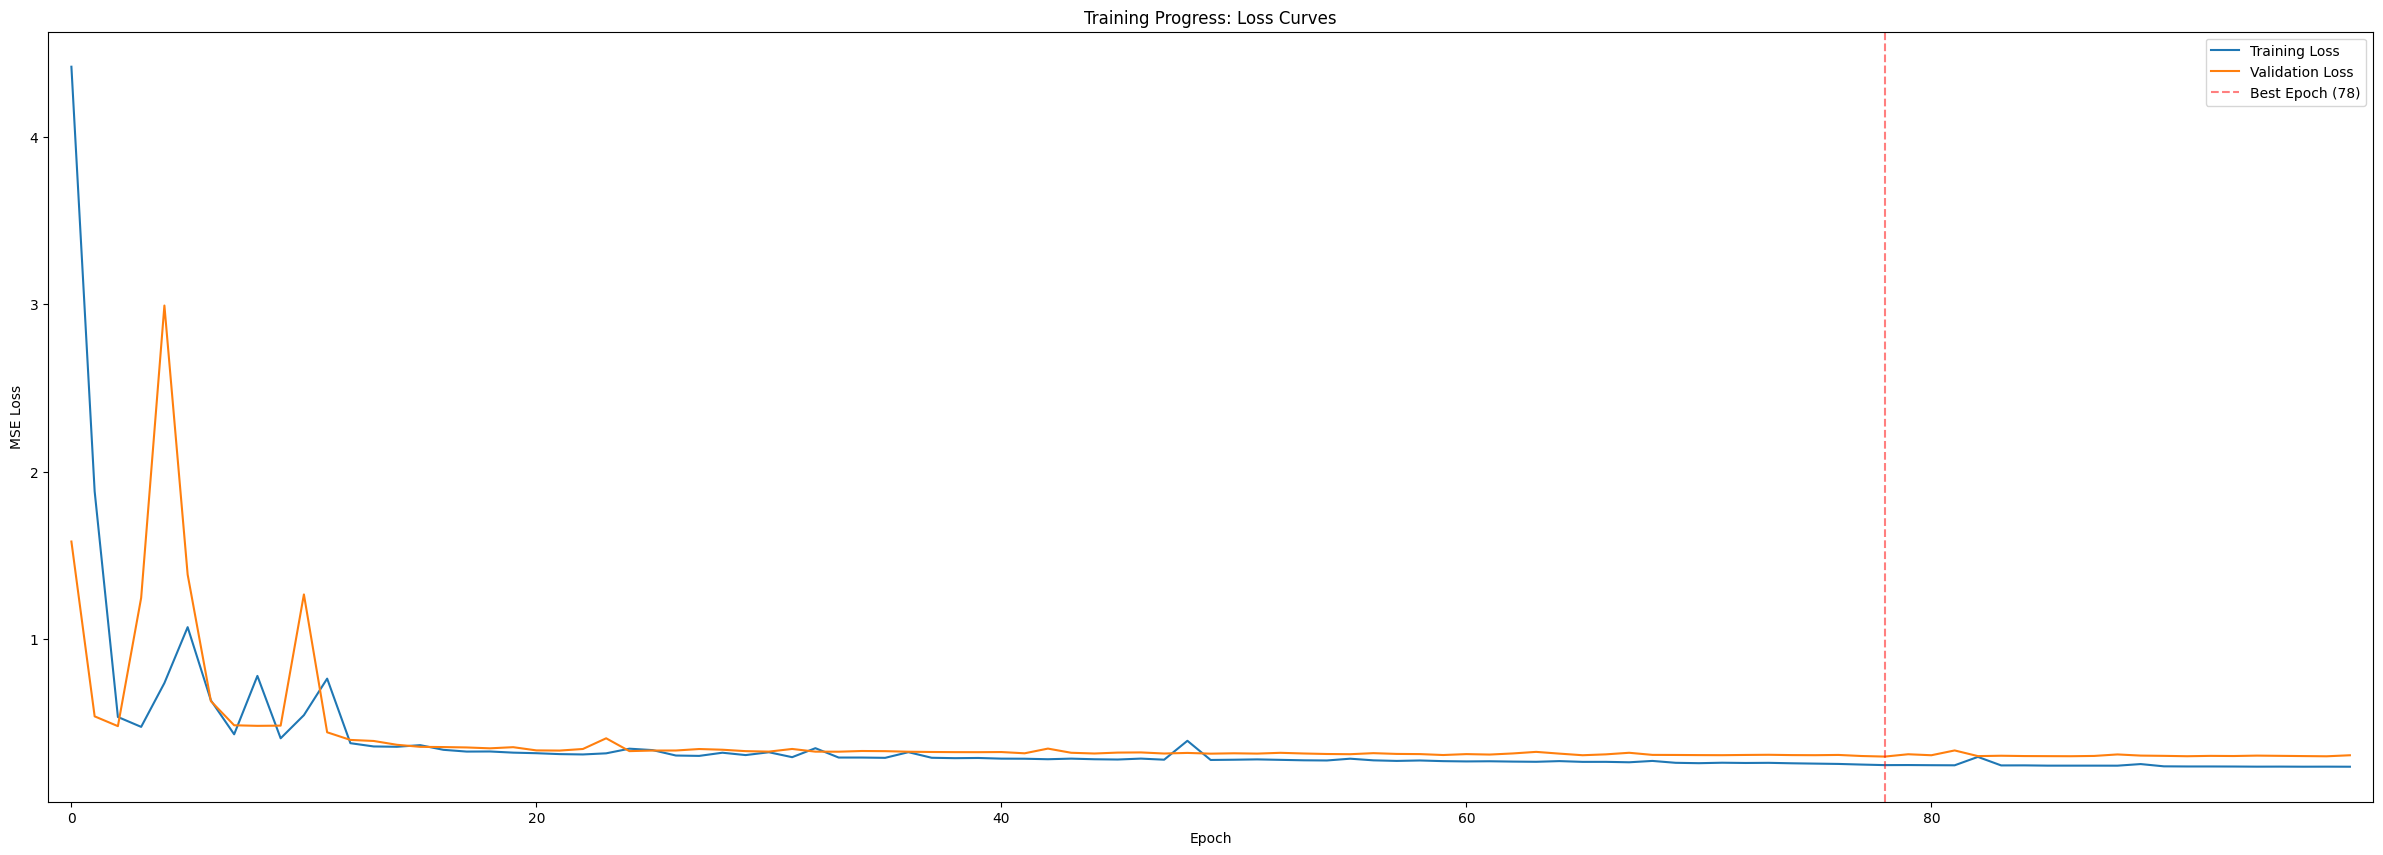

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30, 10))
ax.plot(train_losses, label='Training Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set(xlabel='Epoch', ylabel='MSE Loss', title='Training Progress: Loss Curves', xlim=(-1, len(train_losses)))

# Beste Epoche markieren
best_epoch = np.argmin(val_losses)
ax.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')

ax.legend()

In [10]:
model.load_state_dict(torch.load('./data/01_testat_nn/model.pth'))

train_metrics = compute_metrics(model, train_loader)
val_metrics = compute_metrics(model, val_loader)
test_metrics = compute_metrics(model, test_loader) 
print(f"MSE:  {test_metrics['mse']:.4f}")
print(f"RMSE: {test_metrics['rmse']:.4f} (± ${test_metrics['rmse']:.2f}ht average error)")
print(f"MAE:  {test_metrics['mae']:.4f} (${test_metrics['mae']:.2f}ht average error)")

MSE:  0.2616
RMSE: 0.5115 (± $0.51ht average error)
MAE:  0.3498 ($0.35ht average error)


In [11]:
y[test_ids].flatten().shape, model(x[test_ids]).flatten().shape

(torch.Size([4128]), torch.Size([4128]))

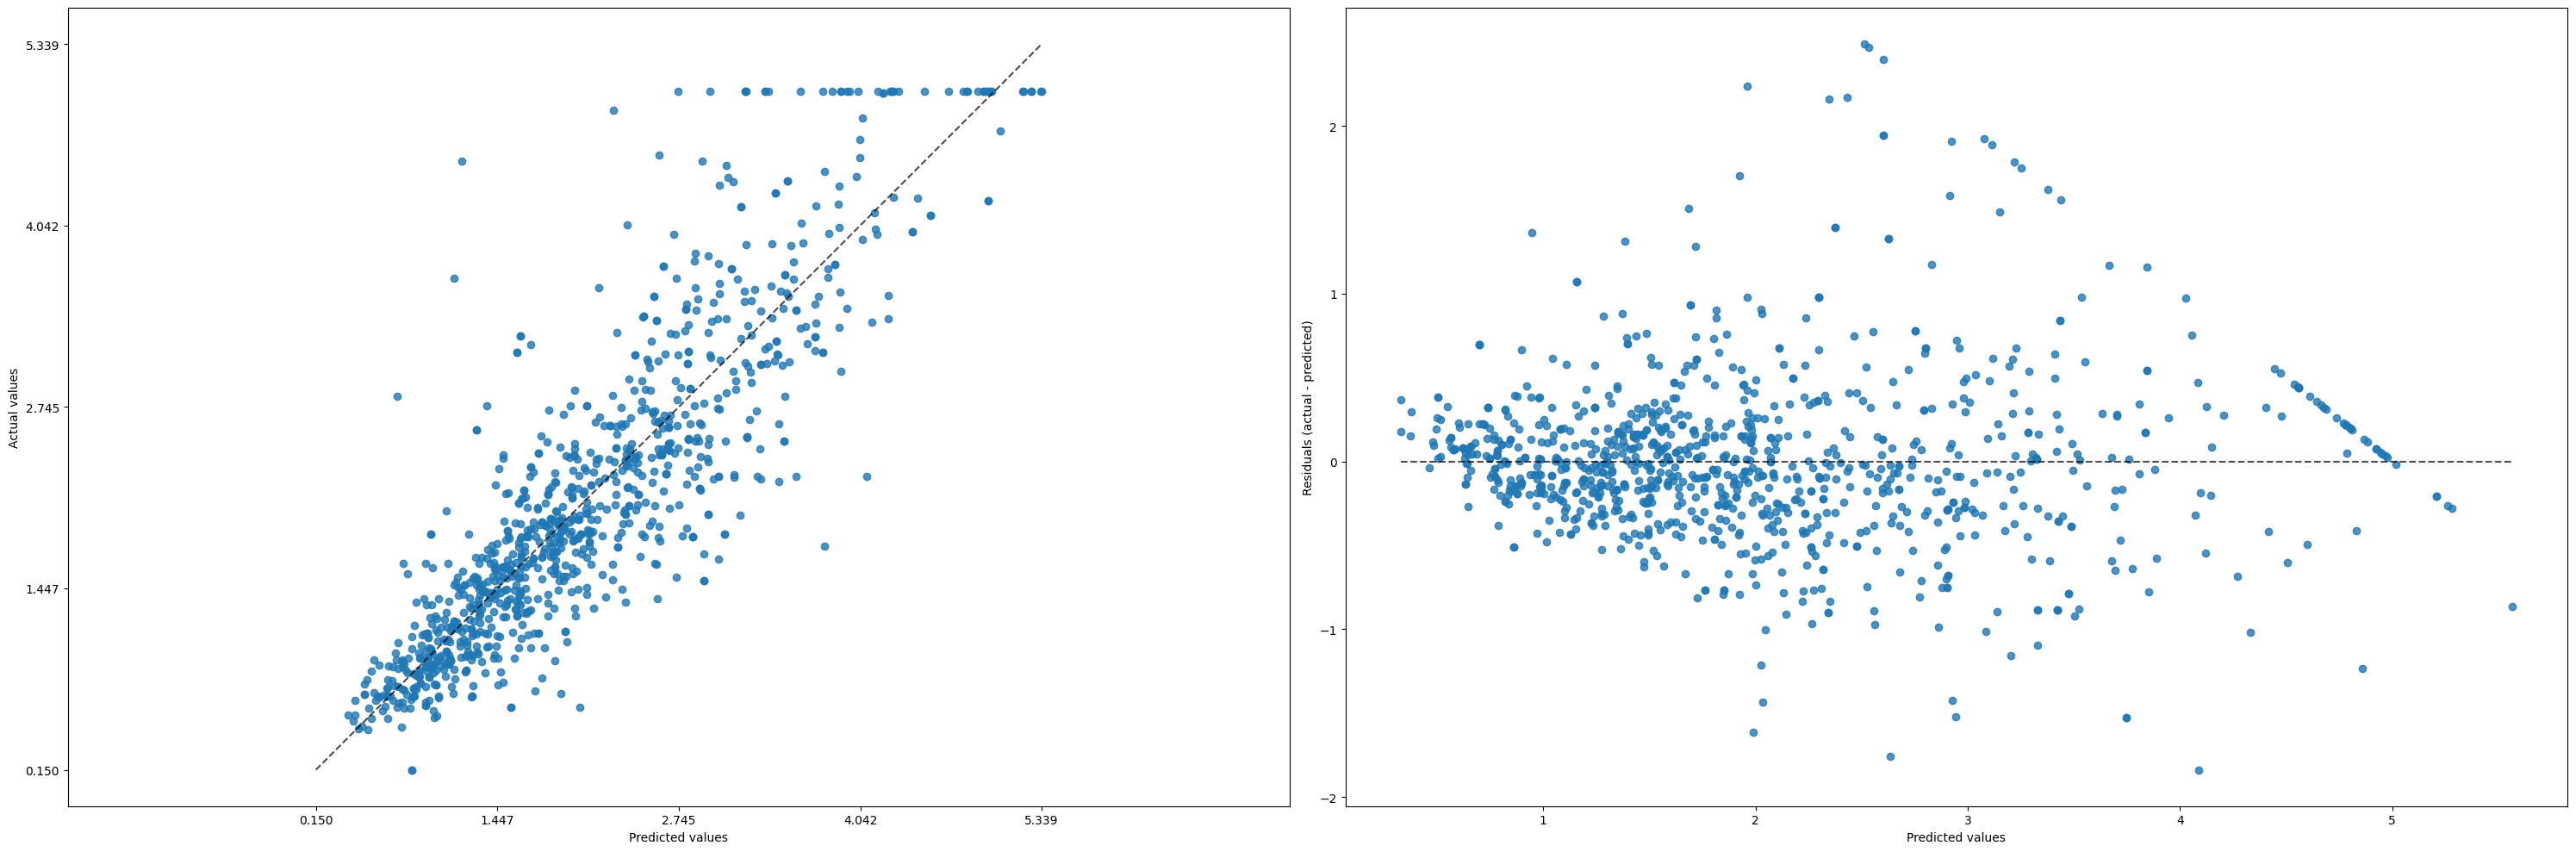

In [12]:
from sklearn.metrics import PredictionErrorDisplay

# Visualisierung der Vorhersagefehler: Actual vs Predicted und Residuals vs Predicted
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

y_true = y[test_ids].numpy().ravel()
y_pred = model(x[test_ids]).detach().numpy().ravel()

PredictionErrorDisplay.from_predictions(
    y_true,
    y_pred,
    ax=ax1,
    kind='actual_vs_predicted',
)
PredictionErrorDisplay.from_predictions(
    y_true,
    y_pred,
    kind='residual_vs_predicted',
    ax=ax2,
)
fig.tight_layout()

## Hyperparameteroptimierung (3 Punkte)

Führen sie eine Hyperparameteroptimierung mit dem Keras-Tuner durch. Anschließend sollen Sie das beste Modell erneut evaluieren und die Veränderung zum vorherigen Begründen.
* a) Hyperparameteroptimierung
* b) Evaluation

### Hyperparameteroptimierung
_Punkte: 2_

In [13]:
import torch.nn as nn

class FlexibleRegressor(nn.Module):
    """
    Flexibles Regressionsmodell mit konfigurierbarer Architektur.
    """
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate):
        super().__init__()
        
        # Schichten dynamisch erstellen
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Ausgabeschicht hinzufügen
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

In [14]:
import optuna

def train_epoch(model, train_loader, criterion, optimizer):
    """Eine Epoche trainieren"""
    model.train()
    train_loss = 0.0
    # correct = 0
    # total = 0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_X.size(0)
        # _, predicted = torch.max(outputs, 1)
        # correct += (predicted == batch_y).sum().item()
        # total += batch_y.size(0)
    
    avg_loss = train_loss / len(train_loader.dataset)
    # accuracy = correct / total
    return avg_loss #, accuracy


def evaluate(model, data_loader, criterion):
    """Modell evaluieren und Verlust berechnen"""
    model.eval()
    eval_loss = 0.0
    # correct = 0
    # total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            eval_loss += loss.item() * batch_X.size(0)

            # _, predicted = torch.max(outputs, 1)
            # correct += (predicted == batch_y).sum().item()
            # total += batch_y.size(0)
    
    avg_loss = eval_loss / len(data_loader.dataset)
    # accuracy = correct / total
    return avg_loss #, accuracy


def train_model(model, train_loader, val_loader, num_epochs=200, lr=0.01, weight_decay=0.0, patience=15, trial=None):
    """Trainingsschleife mit Early Stopping und Optuna-Integration"""
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Fehler soll minimiert werden, daher ein Startwert von unendlich
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer) # Train
        val_loss = evaluate(model, val_loader, criterion)  # Validate
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
        # Meldet den aktuellen MSE an Optuna für das Early Pruning schlechter Trials
        if trial is not None:
            trial.report(val_loss, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()
    
    return best_val_loss, best_epoch

In [ ]:
def objective(trial):
    """
    Zielfunktion für Optuna zur Optimierung.
    Gibt die beste Validierungsgenauigkeit für diese Hyperparameterkonfiguration zurück.
    """
    # Suchraum für Hyperparameter definieren
    n_layers = trial.suggest_int('n_layers', 1, 2)
    hidden_dims = []
    for i in range(n_layers):
        dim = trial.suggest_categorical(f'hidden_dim_layer_{i}', [32, 64, 128, 256])
        hidden_dims.append(dim)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)    
    
    # Model mit den vorgeschlagenen Hyperparametern erstellen
    model = FlexibleRegressor(
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        output_dim=1,
        dropout_rate=dropout_rate
    )
    
    best_val_loss, _ = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=learning_rate,
        weight_decay=weight_decay,
        trial=trial
    )
    
    return best_val_loss

In [ ]:
# SQLite-Datenbank stellt sicher, dass Trainingsfortschritt bei Kernel-Crashes nicht verloren geht
study = optuna.create_study(
    direction='minimize',
    study_name='housing_regression',
    storage='sqlite:///optuna_housing.db',
    load_if_exists=True,
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=15,
        n_warmup_steps=15
    )
)

n_trials = 150 if len(study.trials) == 0 else 0

study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

[I 2026-03-02 10:01:22,263] Using an existing study with name 'housing_regression' instead of creating a new one.


In [25]:
best_params = study.best_trial.params

n_layers = best_params['n_layers']
hidden_dims = [best_params[f'hidden_dim_layer_{i}'] for i in range(n_layers)]

best_model = FlexibleRegressor(
    input_dim=input_dim,
    hidden_dims=hidden_dims,
    output_dim=1,
    dropout_rate=best_params['dropout_rate']
)

best_val_loss, _ = train_model(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay'],
)

print(f"Lowest validation loss: {best_val_loss:.4f}")
print(f"Best hyperparameters: {best_params}")
print(best_model)

  Lowest validation loss: 0.2746
  Best hyperparameters: {'n_layers': 2, 'hidden_dim_layer_0': 256, 'hidden_dim_layer_1': 64, 'weight_decay': 1.8832615364096907e-05, 'learning_rate': 0.0011810178133886127, 'dropout_rate': 0.15748565256666391}
FlexibleRegressor(
  (network): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15748565256666391, inplace=False)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.15748565256666391, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [26]:
train_metrics = compute_metrics(best_model, train_loader)
val_metrics = compute_metrics(best_model, val_loader)
test_metrics = compute_metrics(best_model, test_loader)  
print(f"MSE:  {test_metrics['mse']:.4f}")
print(f"RMSE: {test_metrics['rmse']:.4f} (± ${test_metrics['rmse']:.2f}ht average error)")
print(f"MAE:  {test_metrics['mae']:.4f} (${test_metrics['mae']:.2f}ht average error)")

MSE:  0.2406
RMSE: 0.4905 (± $0.49ht average error)
MAE:  0.3342 ($0.33ht average error)


### Evaluation
_Punkte: 1_

Erläutern sie den unterschied zwischen den beiden Modellen und den Einfluss auf die von Ihnen gemessenen Werte

**Ihre Antwort:**

Das erste Modell nutzt die Funnel-Architektur mit 64 -> 32 Neuronen und verwendet weder Dropout noch Weight Decay. Es neigt dazu, sich an die Trainingsdaten anzupassen, was daran erkennbar ist, dass im Training der `training loss` stetig fällt wobei der `validation loss` stagniert. 

Durch die Hpyerparameteroptimierung wurde das Modell dynamisch strukturiert indem die Architektur, die Lernrate und die Regularisierungsmechanismen (hier Dropout und L2-Regularisierung) gezielt auf die beste Generalisierung abgestimmt wurden. Dadurch lernt das Netz robustere Merkmale und wird toleranter für spezifisches Rauschen in den Daten. 

Nach 150 Trials haben sich die gemessenen Werte des Modells sichtbar verbessert. 
- der MSE ist von 0.2616 auf 0.2406 gesunken
- der RMSE hat sich von 0.5115 auf 0.4905 verringert
- der MAE fiel von 0.3498 auf 0.3342

Das verbesserte Modell kann besser mit Ausreißern umgehen und die Hauspreise insesamt verlässlicher schätzen. 

In [19]:
%load_ext tensorboard
%tensorboard --host 0.0.0.0 --port=8080  --logdir=./data/01_testat_nn/runs 

---

Wahlpflichtach Künstliche Intelligenz II: Testat 